In [117]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping

In [118]:
path = './malimg_dataset/'

In [119]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 1 classes.


In [120]:
familias.class_indices

{'malimg_paper_dataset_imgs': 0}

In [121]:
imgs, labels = next(familias)

In [122]:
imgs.shape

(9339, 64, 64, 3)

In [123]:
labels.shape

(9339, 1)

In [124]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

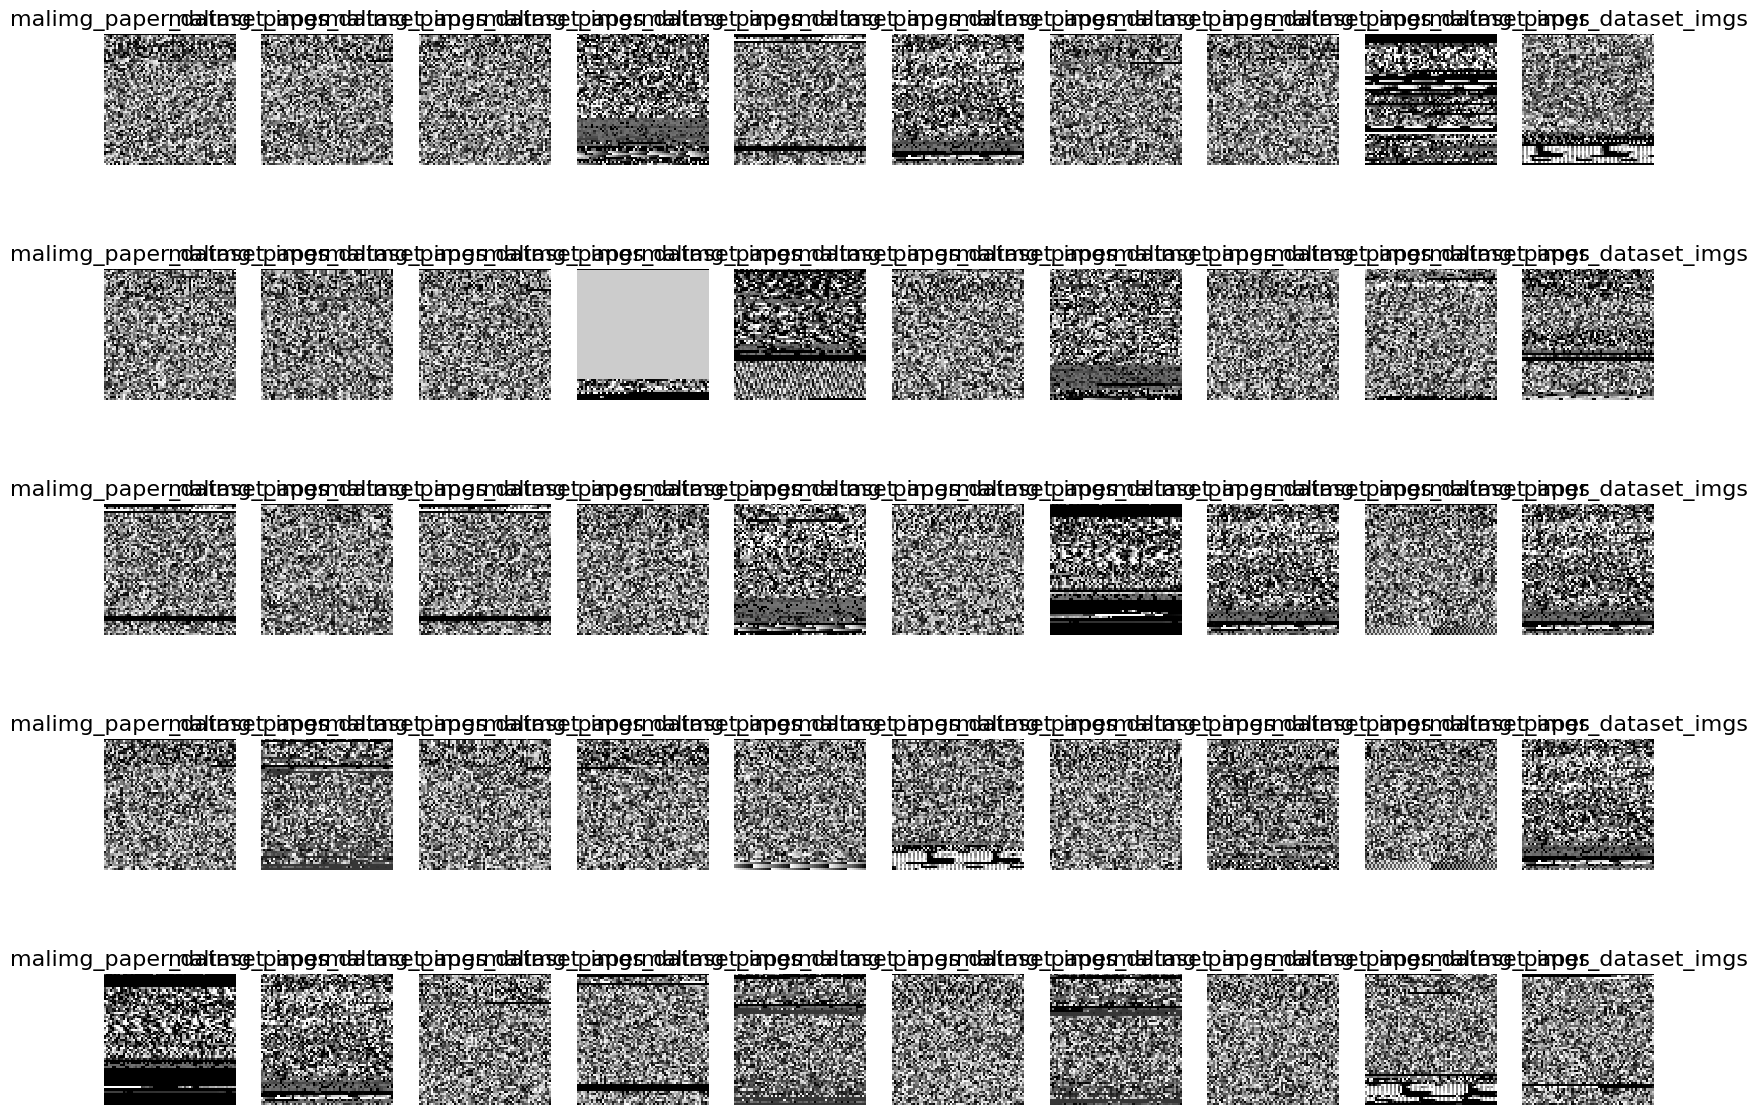

In [126]:

plots(imgs, titles = labels)

### Primera parte

Pre preprocesamiento adicional

Conteo de observaciones

In [127]:
# Path al directorio con las imágenes
path = './malimg_dataset/'

# Creando un generador de datos con escalamiento de las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargando imágenes desde el directorio
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Obteniendo las etiquetas de las clases del generador
class_indices = generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Contando el número de imágenes por clase
for _, labels in generator:
    for label in labels:
        class_name = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_name] += 1
    if generator.batch_index == 0:
        break

print("Conteo de observaciones por familia de malware:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Found 9339 images belonging to 1 classes.
Conteo de observaciones por familia de malware:
malimg_paper_dataset_imgs: 9339


Dividiendo la data en 70% train y 30% test

In [128]:
all_images = []
all_labels = []

# Cargando todas las imágenes y etiquetas
for _ in range(generator.samples // generator.batch_size + 1):
    imgs, labels = next(generator)
    all_images.append(imgs)
    all_labels.append(labels)

# Concatenando todas las imágenes y etiquetas en un solo array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Asegurándose de no tener más datos de los necesarios
all_images = all_images[:generator.samples]
all_labels = all_labels[:generator.samples]

In [129]:
# Dividiendo los datos en un conjunto de entrenamiento y otro de prueba
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print(X_train, X_test)

[[[[0.8941177  0.8941177  0.8941177 ]
   [0.00392157 0.00392157 0.00392157]
   [0.27058825 0.27058825 0.27058825]
   ...
   [0.         0.         0.        ]
   [0.07450981 0.07450981 0.07450981]
   [0.00784314 0.00784314 0.00784314]]

  [[0.27450982 0.27450982 0.27450982]
   [0.14117648 0.14117648 0.14117648]
   [0.         0.         0.        ]
   ...
   [0.2901961  0.2901961  0.2901961 ]
   [0.05882353 0.05882353 0.05882353]
   [0.01568628 0.01568628 0.01568628]]

  [[0.5176471  0.5176471  0.5176471 ]
   [0.92549026 0.92549026 0.92549026]
   [0.35686275 0.35686275 0.35686275]
   ...
   [0.3137255  0.3137255  0.3137255 ]
   [0.76470596 0.76470596 0.76470596]
   [0.01568628 0.01568628 0.01568628]]

  ...

  [[0.7137255  0.7137255  0.7137255 ]
   [0.8000001  0.8000001  0.8000001 ]
   [0.         0.         0.        ]
   ...
   [0.41176474 0.41176474 0.41176474]
   [0.43921572 0.43921572 0.43921572]
   [0.47450984 0.47450984 0.47450984]]

  [[0.42352945 0.42352945 0.42352945]
   [0.1

In [130]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (6537, 64, 64, 3)


In [131]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=3, activation="relu", input_shape=(64, 64, 3)),  
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la primera capa de convolución
        Conv2D(64, kernel_size=3, activation="relu"),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la segunda capa de convolución
        Flatten(),
        Dense(128, activation="relu", 
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),  
        Dropout(0.9),  # Ajustando la tasa de dropout
        Dense(10, activation="softmax")
    ])

    # Compilando el modelo con regularización L1 y L2
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [132]:
from keras.utils import to_categorical

# Convertiendo las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Creando el modelo
model = create_model()

model.fit(X_train, y_train, epochs=5, batch_size=256)

model.save("model.h5")

Train on 6537 samples
Epoch 1/5
6537/6537 [==============================] - 27s 4ms/sample - loss: 18.1364 - accuracy: 0.7453
Epoch 2/5
6537/6537 [==============================] - 26s 4ms/sample - loss: 12.6165 - accuracy: 0.9540
Epoch 3/5
6537/6537 [==============================] - 26s 4ms/sample - loss: 7.6555 - accuracy: 0.9766
Epoch 4/5
6537/6537 [==============================] - 28s 4ms/sample - loss: 4.2319 - accuracy: 0.9832
Epoch 5/5
6537/6537 [==============================] - 27s 4ms/sample - loss: 2.3625 - accuracy: 0.9856


### Segunda parte

Cargando el modelo

In [134]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier

# Desactivando la ejecución ansiosa
tf.compat.v1.disable_eager_execution()

# Cargando el modelo
model = load_model('model.h5')

# Envolviendo el modelo con ART
classifier = KerasClassifier(model=model)

Ataque de evasión

In [183]:
from art.attacks.evasion import FastGradientMethod
from sklearn.metrics import accuracy_score

# Configurando el ataque FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.001)  # eps controla la magnitud del ataque

# Generando ejemplos de ataque
x_test_adv = attack_fgsm.generate(x=X_test)

# Evaluando el modelo en datos de prueba normales para comparar
predictions_normal = classifier.predict(X_test)

# Asegurar que las etiquetas tengan el formato correcto
y_test = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
predictions_normal = np.argmax(predictions_normal, axis=1) if len(predictions_normal.shape) > 1 else predictions_normal

# Calcular accuracy utilizando accuracy_score
accuracy_normal = accuracy_score(y_test, predictions_normal)
print(f"Accuracy en datos normales: {accuracy_normal * 100:.2f}%")

# Evaluando el modelo con los datos de ataque
predictions = classifier.predict(x_test_adv)

# Asegurar que las etiquetas tengan el formato correcto
predictions = np.argmax(predictions, axis=1) if len(predictions.shape) > 1 else predictions

# Calcular accuracy utilizando accuracy_score
accuracy_fgsm = accuracy_score(y_test, predictions)
print(f"Accuracy en datos de ataque FGSM: {accuracy_fgsm * 100:.2f}%")

Accuracy en datos normales: 95.25%
Accuracy en datos de ataque FGSM: 93.58%



Descripción del ataque de evasión utilizando FGSM:

El código presentado implementa un ataque adversario usando el método "Fast Gradient Sign Method" (FGSM) a través de la librería ART (Adversarial Robustness Toolbox) en Python. En primer lugar, se importa la librería FGSM y se configura el modelo "classifier" que se desea atacar, junto con la magnitud del ataque, definida por un epsilon (eps) de 0.1.

A continuación, se generan imágenes adversarias y se asignan a la variable "x_test_adv", modificando las imágenes de prueba originales almacenadas en la variable "X_test" con el propósito de engañar al modelo. El modelo se evalúa inicialmente con las imágenes de prueba originales para establecer una línea base de precisión, denominada "accuracy_normal", lo que permite observar el rendimiento del modelo en condiciones normales.

Finalmente, se evalúa la precisión del modelo utilizando las imágenes adversarias para determinar cómo el ataque FGSM afecta su rendimiento. Este análisis es crucial para comprender la robustez del modelo frente a ataques adversarios, permitiendo identificar y mejorar su resistencia frente a manipulaciones malintencionadas. Este proceso es fundamental en la seguridad de los modelos de aprendizaje automático, ya que ayuda a identificar vulnerabilidades y a desarrollar medidas para mitigar los riesgos asociados con ataques adversarios.

Ataque de extracción

In [171]:
# Importación de librerías necesarias
import numpy as np
import tensorflow as tf
from art.estimators.classification import KerasClassifier
from art.attacks.extraction import CopycatCNN
from sklearn.metrics import accuracy_score

# Cargando el modelo preentrenado (víctima)
model_victim = tf.keras.models.load_model('model.h5')

# Envolviendo el modelo en un clasificador ART
classifier_victim = KerasClassifier(model=model_victim, clip_values=(0, 1))

thieved_model = create_model()

# Envolviendo el thieved model con un clasificador de ART
thieved_classifier = KerasClassifier(model=thieved_model, clip_values=(0, 1))

X_data = np.random.rand(100, 64, 64, 3)  # 100 imágenes aleatorias como ejemplo

# Configurando el ataque Copycat CNN
attack = CopycatCNN(classifier=classifier_victim, batch_size_fit=256, batch_size_query=256, nb_epochs=5, nb_stolen=100)

# Ejecutando el ataque para extraer un nuevo modelo
thieved_classifier = attack.extract(x=X_data, thieved_classifier=thieved_classifier)

# Realizando las predicciones
predictions = thieved_classifier.predict(X_test)

if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

if len(predictions.shape) > 1:
    predictions = np.argmax(predictions, axis=1)

# Calculando el accuracy del modelo víctima
predictions_original = classifier_victim.predict(X_test)
if len(predictions_original.shape) > 1:
    predictions_original = np.argmax(predictions_original, axis=1)

accuracy_original = np.mean(predictions_original == y_test)
print(f"Accuracy del modelo original: {accuracy_original * 100:.2f}%")

# Calculando el accuracy del modelo atacante
accuracy_thieved = np.mean(predictions == y_test)
print(f"Accuracy del thieved model: {accuracy_thieved * 100:.2f}%")

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy del modelo original: 95.25%
Accuracy del thieved model: 94.33%


**Descripción del ataque de extracción utilizando Copycat CNN:**

El código descrito implementa un ataque de extracción conocido como Copycat CNN para replicar la funcionalidad de un modelo preentrenado mediante la biblioteca ART en Python. Inicialmente, se importan las bibliotecas necesarias y se carga el modelo preentrenado, denominado "modelo víctima". Este modelo se envuelve en un clasificador ART para ajustar sus valores de entrada entre 0 y 1.

Luego, se crea un nuevo modelo, llamado "modelo robado" (thieved model), que también se envuelve en un clasificador ART. Se preparan 100 imágenes aleatorias de 64x64 píxeles con 3 canales (imágenes a color) para emplearlas en el ataque. El ataque Copycat CNN se configura con parámetros como el tamaño del lote y el número de épocas. Posteriormente, se ejecuta utilizando el clasificador del modelo víctima y las imágenes aleatorias para entrenar el modelo robado a imitar el comportamiento del modelo original.

Finalmente, ambos modelos (el modelo víctima y el modelo robado) se evalúan en un conjunto de prueba "X_test". Se ajustan las predicciones y etiquetas para calcular la precisión de clasificación. Se compara la precisión del modelo original con la del modelo robado para determinar la efectividad del ataque. Este procedimiento es crucial en el ámbito de la seguridad, ya que permite comprender y mitigar los riesgos asociados con la clonación no autorizada de modelos sensibles.